In [22]:
import numpy as np
from scipy.integrate import dblquad
from scipy.integrate import quad
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})
%matplotlib widget

class fixed_values:
  def __init__(self):
    self.h=4.135667e-9 #eV us
    self.hbar=self.h/(2*np.pi) #eV us rad-1
    self.c=299792458 #um/us
    self.k_B=8.617343e-5 #eV/K
    self.eta_pb_max=0.59
    self.energy_au=27.211386 #eV
    self.time_au=2.418884e-11 #us
    self.length_au=5.291772e-5 #um
    self.N_A = 6.022e23
    self.m_e = 5.68563006e-12 #eV s2 m-2
consts = fixed_values()

In [23]:
def calc_RS(metal,T):
    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    v_fermi = p_fermi/mstar
    epsilonF = (consts.hbar)**2/(2*mstar)*(3*np.pi**2*metal.n)**(2/3)
    
    tau_elastic = metal.nue*metal.D*mstar/metal.n # <= Einstein relation (sigma = e^2 N(0) D) and drude effective mass, tau elastic time
    l=v_fermi*tau_elastic
    beta = (2/3 * epsilonF)**2 * metal.nue/(2*metal.rho_m*metal.v_L**2)
    tau_epsilon = 1/(np.pi**4*beta/5 * p_fermi*l*T**4/(p_fermi*metal.v_T)**3 * (1+3/2*(metal.v_L/metal.v_T)**5) * consts.k_B**4 / consts.hbar**2)
    tau_0 = 4.20*tau_epsilon # kaplan 18
    return tau_0

def calc_KSK(metal):
  p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
  k_fermi = p_fermi/consts.hbar
  mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
  v_fermi = p_fermi/mstar
  tau_elastic = metal.nue*metal.D*mstar/metal.n # <= Einstein relation (sigma = e^2 N(0) D) and drude effective mass, tau elastic time

  l=v_fermi*tau_elastic

  qD = metal.E_D/(consts.hbar*metal.v_L)

  Phi_L = lambda x : 2/np.pi * ((x*np.arctan(x))/(x-np.arctan(x)) - 3/x)
  Phi_T = lambda x : 3/np.pi * (2*x**3 + 3*x - 3*(x**2+1) * np.arctan(x))/x**4
  gL =  p_fermi**2 / (3*consts.m_e*np.sqrt(metal.rho_m)*metal.v_L)

  alpha2F = lambda omega : gL**2 * (mstar*qD**2*omega**2)/(4*p_fermi**2 *metal.T_D**2) * (Phi_L(omega*l/metal.v_L)+(metal.v_L/metal.v_T)**4 * 2 * Phi_T(omega*l/metal.v_T)) * consts.hbar**3 * consts.k_B**-2

  alpha2_av = quad(alpha2F,0,metal.omega_D)[0] / 3
  return alpha2_av

class superconductor():
  def __init__(self,metaldict,disordered=False):
    self.nue = metaldict['nue']
    self.D = metaldict['D']
    self.Tc = metaldict['Tc']
    self.Delta = 1.768*consts.k_B*self.Tc #eV
    self.T_D = metaldict['T_D']
    self.omega_D = consts.k_B*self.T_D/consts.hbar #in MHz rad
    self.v_L = metaldict['v_L']
    self.v_T = metaldict['v_T']

    rho_m = metaldict['rho_m (g cm-3)']
    self.Z = metaldict['Z']
    m_a = metaldict['m_a (u)']

    self.N = consts.N_A*rho_m/m_a * 1e-12 # atoms um-3
    self.n = self.N*self.Z # electrons um-3
    self.rho_m = rho_m*6.242e15 *1e-12#eV us2 um-2 um-3

    self.rs = (3/(4*np.pi*self.n))**(1/3)
    self.rs_au = self.rs / consts.length_au
    
    self.E_D = consts.k_B*self.T_D

    if disordered==False:
      self.tau_0 = 0.11 #us
      self.alpha2_av = metaldict['alpha2_av']
    else:
      self.tau_0 = calc_RS(self,self.Tc)
      self.alpha2_av = calc_KSK(self)

aluminium = {
    'nue' : 17.2e9, #eV-1 um-3
    'D' : 15000, #um2 us-1
    'Tc' : 1.11, #K
    'T_D' : 737.852309310353, #K
    'v_L' : 6420, #um/us
    'v_T' : 3040, #um/us
    'rho_m (g cm-3)' : 2.7, #g cm-3
    'Z' : 3, #valence electrons per atom
    'm_a (u)' : 26.982, #u
    'alpha2_av' : 1.93e-3, #eV
    'tau_0' : 0.11, #us
}

tantalum = {
    'nue' : 30.3e9, #eV-1 um-3
    'D' : 75, #um2 us-1
    'Tc' : 1.11, #K
    'T_D' : 221, #K
    'v_L' : 4.35e3, #um/us
    'v_T' : 1.74e3, #um/us
    'rho_m (g cm-3)' : 17.1, #g cm-3
    'Z' : 2, #valence electrons per atom
    'm_a (u)' : 180.94788, #u
  }

T=0.02 #K
Al = superconductor(aluminium,disordered=False)
bTa = superconductor(tantalum,disordered=True)

In [24]:
def calc_LP(metal,energy):
    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    epsilonF = (consts.hbar)**2/(2*mstar)*(3*np.pi**2*metal.n)**(2/3)
    tau_ee = 1/((energy**2 / (consts.hbar*epsilonF))*metal.rs_au**0.5 / 7.96)
    return tau_ee

def calc_pippard(metal,energy):
    omega = energy/consts.hbar

    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    v_fermi = p_fermi/mstar
    tau_elastic = metal.nue*metal.D*mstar/metal.n # <= Einstein relation (sigma = e^2 N(0) D) and drude effective mass, tau elastic time

    l=v_fermi*tau_elastic

    k_L=omega/metal.v_L
    alpha_L = metal.n*mstar/(metal.rho_m*metal.v_L*tau_elastic) * (1/3 * (k_L**2*l**2*np.arctan(k_L*l)/(k_L*l-np.arctan(k_L*l))) - 1)
    tau_ph_L = 1/(metal.v_L*alpha_L)

    k_T=omega/metal.v_T
    g = 3/(2*k_T**2*l**2)*((k_T**2*l**2+1)/(k_T*l)*np.arctan(k_T*l)-1)
    alpha_T = metal.n*mstar/(metal.rho_m*metal.v_T*tau_elastic) * (1-g)/g
    tau_ph_T = 1/(metal.v_T*alpha_T)
    return tau_ph_L,tau_ph_T,tau_elastic

@np.vectorize
def calc_kaplan(metal,energy,T):
    tau_s = metal.tau_0/((metal.Delta/(consts.k_B*metal.Tc))**3*(1/3*((energy/metal.Delta)**2-1)**(3/2)+5/2*((energy/metal.Delta)**2-1)**(1/2)-metal.Delta/(2*energy)*(1+4*(energy/metal.Delta)**2)*np.log(energy/metal.Delta+((energy/metal.Delta)**2-1)**(1/2))))

    f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)

    RB_int = lambda omega : 1/(omega**2 - metal.Delta**2)**0.5 * (omega*(energy-omega)+metal.Delta**2)/((energy-omega)**2-metal.Delta**2)**0.5 * (1-f(omega)-f(energy-omega))
    Rphs_int = lambda omega : 1/(omega**2 - metal.Delta**2)**0.5 * (omega*(energy+omega)-metal.Delta**2)/((energy+omega)**2-metal.Delta**2)**0.5 * (f(omega)-f(energy+omega))

    RB = 4*np.pi*metal.nue*metal.alpha2_av/(consts.hbar*metal.n) * quad(RB_int,metal.Delta,energy-metal.Delta)[0]
    Rphs = 8*np.pi*metal.nue*metal.alpha2_av/(consts.hbar*metal.n) * quad(Rphs_int,metal.Delta,np.inf)[0]


    return tau_s, 1/RB#, 1/Rphs

/tmp/ipykernel_10515/588910966.py:34: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


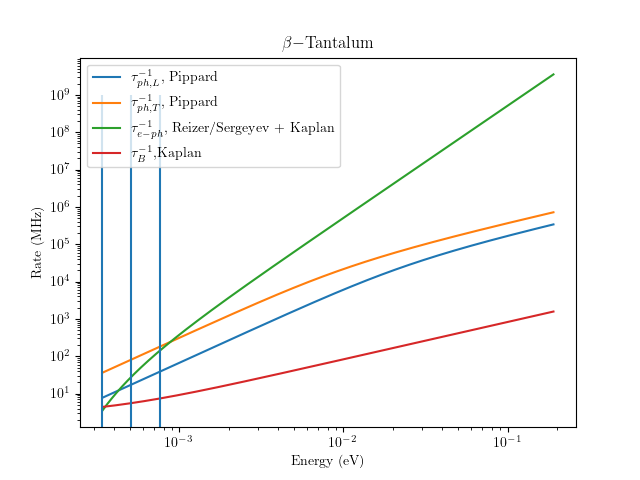

In [33]:
E_range = np.geomspace(2.01*bTa.Delta,10*bTa.E_D,1000)
tau_ee = calc_LP(bTa,E_range)
tau_ph_L,tau_ph_T,_ = calc_pippard(bTa,E_range)
tau_s,tau_B = calc_kaplan(bTa,E_range,T)

plt.figure()
#plt.loglog(E_range,1/tau_ee,label=r'$\frac{1}{\tau_{e-e}}$')
plt.loglog(E_range,1/tau_ph_L,label=r'$\tau_{ph,L}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_ph_T,label=r'$\tau_{ph,T}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_s,label=r'$\tau_{e-ph}^{-1}$, Reizer/Sergeyev + Kaplan')
plt.loglog(E_range,1/tau_B,label=r'$\tau_{B}^{-1}$,Kaplan')
#plt.loglog(E_range,1/tau_phs,label=r'$\tau_{phs}^{-1}$, Kaplan')

plt.vlines([2*bTa.Delta,3*bTa.Delta,4.5*bTa.Delta],1,1e9)

plt.legend()
plt.title(r'$\beta-$Tantalum')
plt.xlabel('Energy (eV)')
plt.ylabel('Rate (MHz)')
plt.show()

/tmp/ipykernel_10515/588910966.py:34: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


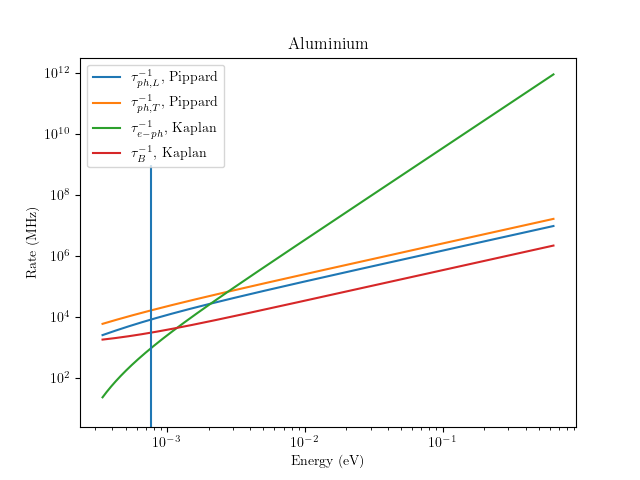

In [34]:
E_range = np.geomspace(2.01*Al.Delta,10*Al.E_D,1000)
tau_ee = calc_LP(Al,E_range)
tau_ph_L,tau_ph_T,_ = calc_pippard(Al,E_range)
tau_s,tau_B = calc_kaplan(Al,E_range,T)

plt.figure()
#plt.loglog(E_range,1/tau_ee,label=r'$\frac{1}{\tau_{e-e}}$')
plt.loglog(E_range,1/tau_ph_L,label=r'$\tau_{ph,L}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_ph_T,label=r'$\tau_{ph,T}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_s,label=r'$\tau_{e-ph}^{-1}$, Kaplan')
plt.loglog(E_range,1/tau_B,label=r'$\tau_{B}^{-1}$, Kaplan')
#plt.loglog(E_range,1/tau_phs,label=r'$\tau_{phs}^{-1}$, Kaplan')

plt.vlines(4.5*Al.Delta,1,1e9)

plt.legend()
plt.title('Aluminium')
plt.xlabel('Energy (eV)')
plt.ylabel('Rate (MHz)')
plt.show()

In [27]:
print(calc_kaplan(bTa,4.5*bTa.Delta,T)[0])
print(calc_kaplan(Al,4.5*Al.Delta,T)[0])

0.007009524055459557
0.001035752897438511


/tmp/ipykernel_10515/588910966.py:34: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


In [28]:
E1 = 67*Al.E_D
tau_ee = calc_LP(Al,E1)
_,_,tau_elastic = calc_pippard(Al,E1)
print('tau_ee\t\t',tau_ee)
print('tau_elastic\t',tau_elastic)

tau_ee		 1.5805269281614386e-09
tau_elastic	 1.2000521132629166e-08


In [29]:
lambda_au = (1/(bTa.E_D*bTa.tau_0))*(bTa.E_D/(consts.k_B*bTa.Tc))**3 * consts.energy_au*consts.time_au

p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*bTa.n)**(2/3))
k_fermi = p_fermi/consts.hbar
mstar = 2*consts.hbar**2*bTa.nue*np.pi**2/k_fermi # from suppl
epsilonF = (consts.hbar)**2/(2*mstar)*(3*np.pi**2*bTa.n)**(2/3)

E1 = 2.82*bTa.E_D*bTa.rs_au**(-1/4)*(lambda_au/3 * epsilonF/bTa.E_D)**(1/2)

tau_ee = calc_LP(bTa,E1)
_,_,tau_elastic = calc_pippard(bTa,E1)
print('tau_ee\t\t',tau_ee)
print('tau_elastic\t',tau_elastic)


tau_ee		 2.8323914144757607e-07
tau_elastic	 3.450771260601039e-10


In [30]:
length = 6
width = 6
height = 0.04

def distfunc(phi,theta):
    return np.min(np.stack([height/2/np.sqrt(1-np.sin(phi)**2),length/2/np.sqrt(1-np.sin(theta)**2),width/2/np.sqrt(1-np.sin(np.pi/2-theta)**2)],axis=-1),axis=-1)

mfp = dblquad(distfunc,0,np.pi/2,0,np.pi/2)[0]*4/np.pi**2

D_ph = mfp*bTa.v_L/3

print(D_ph, '= D (um2/us)')
mfp

125.79628021744543 = D (um2/us)


0.08675605532237615